In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
from collections import Counter
warnings.filterwarnings('ignore')

### 1. 필요없는 열 제거

In [2]:
df = pd.read_csv("./서울특별시 일반음식점 인허가 정보.csv", encoding='cp949')
print(df.columns)

Index(['개방자치단체코드', '관리번호', '인허가일자', '인허가취소일자', '영업상태코드', '영업상태명', '상세영업상태코드',
       '상세영업상태명', '폐업일자', '휴업시작일자', '휴업종료일자', '재개업일자', '전화번호', '소재지면적',
       '소재지우편번호', '지번주소', '도로명주소', '도로명우편번호', '사업장명', '최종수정일자', '데이터갱신구분',
       '데이터갱신일자', '업태구분명', '좌표정보(X)', '좌표정보(Y)', '위생업태명', '남성종사자수', '여성종사자수',
       '영업장주변구분명', '등급구분명', '급수시설구분명', '총인원', '본사종업원수', '공장사무직종업원수',
       '공장판매직종업원수', '공장생산직종업원수', '건물소유구분명', '보증액', '월세액', '다중이용업소여부', '시설총규모',
       '전통업소지정번호', '전통업소주된음식', '홈페이지'],
      dtype='object')


In [3]:
df = df[['상세영업상태코드', '도로명주소' , '사업장명', '업태구분명', '좌표정보(X)', '좌표정보(Y)']]
df.head()

,상세영업상태코드,도로명주소,사업장명,업태구분명,좌표정보(X),좌표정보(Y)
0,1,NaN,일식동경,일식,NaN,NaN
1,1,서울특별시 종로구 삼일대로 382 (관철동),상해,분식,198867.702591,451824.281126
2,1,서울특별시 관악구 신림로59길 15-13 4층 (신림동),미쿠,일식,193687.348199,442284.164025
3,1,서울특별시 구로구 구로동로22길 21 1층 (구로동),여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
4,1,서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동),카페디퍼,기타,204776.548264,444677.642985


### 2. 결측치 제거

In [4]:
def check_null(df):    
    total_cnt = 0
    for i in df.columns:
        cnt = sum(df[i].isnull())
        total_cnt += cnt
        if cnt:
            print(f'{i}열에 결측치{cnt}개')
        else:
            print(f'{i}열에 결측치 없음')
    if total_cnt == 0:
        print('모든 열에 결측치 없음')
    else:
        print(f'총 결측치 {total_cnt}개')

In [5]:
check_null(df)

상세영업상태코드열에 결측치 없음
도로명주소열에 결측치250895개
사업장명열에 결측치1개
업태구분명열에 결측치21개
좌표정보(X)열에 결측치24965개
좌표정보(Y)열에 결측치24965개
총 결측치 300847개


In [6]:
df = df.dropna()
df.head()

,상세영업상태코드,도로명주소,사업장명,업태구분명,좌표정보(X),좌표정보(Y)
1,1,서울특별시 종로구 삼일대로 382 (관철동),상해,분식,198867.702591,451824.281126
2,1,서울특별시 관악구 신림로59길 15-13 4층 (신림동),미쿠,일식,193687.348199,442284.164025
3,1,서울특별시 구로구 구로동로22길 21 1층 (구로동),여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
4,1,서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동),카페디퍼,기타,204776.548264,444677.642985
5,1,서울특별시 동대문구 난계로30길 28-7 1층 (신설동),메이크데이(MakeDay),기타,202114.228397,452392.093759


### 3. 폐업 음식점 제거

In [7]:
df["상세영업상태코드"].value_counts().sort_index()

1    121762
2    101045
Name: 상세영업상태코드, dtype: int64

In [8]:
df = df[df["상세영업상태코드"] == 1]

In [9]:
df["상세영업상태코드"].value_counts().sort_index()
df = df.drop(columns='상세영업상태코드')
df.head()

,도로명주소,사업장명,업태구분명,좌표정보(X),좌표정보(Y)
1,서울특별시 종로구 삼일대로 382 (관철동),상해,분식,198867.702591,451824.281126
2,서울특별시 관악구 신림로59길 15-13 4층 (신림동),미쿠,일식,193687.348199,442284.164025
3,서울특별시 구로구 구로동로22길 21 1층 (구로동),여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
4,서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동),카페디퍼,기타,204776.548264,444677.642985
5,서울특별시 동대문구 난계로30길 28-7 1층 (신설동),메이크데이(MakeDay),기타,202114.228397,452392.093759


### 4. 업종구분 재분류

In [10]:
df["업태구분명"].value_counts().sort_index()

감성주점                223
경양식                9228
기타                17812
김밥(도시락)             583
까페                 2092
냉면집                 103
라이브카페               190
복어취급                 51
분식                 9048
뷔페식                 457
식육(숯불구이)            882
외국음식전문점(인도태국등)     1370
이동조리                  7
일식                 6118
전통찻집                 51
정종/대포집/소주방         2229
중국식                4531
출장조리                100
커피숍                   3
키즈카페                 66
탕류(보신용)             143
통닭(치킨)             2530
패밀리레스트랑             171
패스트푸드               705
한식                52145
호프/통닭             10353
회집                  276
횟집                  295
Name: 업태구분명, dtype: int64

In [11]:
a = [['경양식','뷔페식','패밀리레스트랑'], #양식
     ['회집','횟집','복어취급'], #해산물
     ['분식','냉면집','김밥(도시락)'], #분식
     ['통닭(치킨)','호프/통닭'], #치킨
     ['한식','탕류(보신용)'], #한식
     ['커피숍','까페','키즈카페','라이브카페','전통찻집','기타'], #카페
     ['정종/대포집/소주방','감성주점'], #술집
     ['식육(숯불구이)'], #고기
     ['중국식'], #중식
     ['외국음식전문점(인도태국등)'], #외국음식
     ['출장조리','이동조리']] #error
# 일식, 패스트푸드 그대로 사용

b = ['양식','해산물','분식','치킨','한식','카페','술집','고기','중식','외국음식','error']

food_list = df["업태구분명"].to_list()
for i,j in enumerate(food_list):
    for x,y in enumerate(a):
        if j in y:
            food_list[i] = b[x]
            
df.insert(3,'업종',food_list)
df = df.drop(columns='업태구분명')
df = df[df['업종'] != 'error']
df.head()

,도로명주소,사업장명,업종,좌표정보(X),좌표정보(Y)
1,서울특별시 종로구 삼일대로 382 (관철동),상해,분식,198867.702591,451824.281126
2,서울특별시 관악구 신림로59길 15-13 4층 (신림동),미쿠,일식,193687.348199,442284.164025
3,서울특별시 구로구 구로동로22길 21 1층 (구로동),여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
4,서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동),카페디퍼,카페,204776.548264,444677.642985
5,서울특별시 동대문구 난계로30길 28-7 1층 (신설동),메이크데이(MakeDay),카페,202114.228397,452392.093759


### 5. 도로명주소에서 자치구, 자치동 분류

In [12]:
address_list = df['도로명주소'].to_list()
address_list[:5]

['서울특별시 종로구 삼일대로 382 (관철동)',
 '서울특별시 관악구 신림로59길 15-13 4층 (신림동)',
 '서울특별시 구로구 구로동로22길 21 1층 (구로동)',
 '서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동)',
 '서울특별시 동대문구 난계로30길 28-7 1층 (신설동)']

In [13]:
gu_list = [address_list[i].split()[1] for i in range(len(address_list))]
gu_list[:5]

['종로구', '관악구', '구로구', '강남구', '동대문구']

In [14]:
dong_list = []
for i in range(len(address_list)):
    try:
        dong_list.append(re.findall('\(.+동',address_list[i])[0].split()[0][1:].split('(')[0]) #정규표현식
    except:
        dong_list.append('error')
dong_list[:5]

['관철동', '신림동', '구로동', '대치동', '신설동']

In [15]:
cnt_list = Counter(dong_list)
error_list = [i for i in cnt_list if cnt_list[i] < 50]

for i,j in enumerate(dong_list):
    if j in error_list:
        dong_list[i] = 'error'

In [16]:
Counter(dong_list)

Counter({'관철동': 360,
         '신림동': 2407,
         '구로동': 2094,
         '대치동': 1350,
         '신설동': 208,
         '응암동': 707,
         '논현동': 2016,
         '수유동': 1448,
         '일부)호': 64,
         '역삼동': 3050,
         '상봉동': 618,
         '잠원동': 463,
         '화곡동': 2210,
         '양평동': 587,
         '암사동': 427,
         '창신동': 430,
         '성수동': 1641,
         '봉천동': 2150,
         '공릉동': 757,
         'error': 7600,
         '성내동': 1001,
         '필동': 255,
         '종암동': 278,
         '창동': 788,
         '서계동': 98,
         '우이동': 168,
         '도곡동': 495,
         '화양동': 887,
         '송파동': 557,
         '상일동': 167,
         '마곡동': 852,
         '서초동': 2143,
         '영등포동': 993,
         '천호동': 1053,
         '연남동': 718,
         '신천동': 412,
         '잠실동': 1006,
         '신사동': 2247,
         '가산동': 1008,
         '공덕동': 385,
         '금호동': 360,
         '제기동': 443,
         '상수동': 327,
         '진관동': 298,
         '서교동': 1817,
         '중화동': 424,
         '문정동': 1

In [17]:
df.insert(1,'구',gu_list)
df.insert(2,'동',dong_list)
df.head()

,도로명주소,구,동,사업장명,업종,좌표정보(X),좌표정보(Y)
1,서울특별시 종로구 삼일대로 382 (관철동),종로구,관철동,상해,분식,198867.702591,451824.281126
2,서울특별시 관악구 신림로59길 15-13 4층 (신림동),관악구,신림동,미쿠,일식,193687.348199,442284.164025
3,서울특별시 구로구 구로동로22길 21 1층 (구로동),구로구,구로동,여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
4,서울특별시 강남구 삼성로85길 33 1층 102-2호 (대치동),강남구,대치동,카페디퍼,카페,204776.548264,444677.642985
5,서울특별시 동대문구 난계로30길 28-7 1층 (신설동),동대문구,신설동,메이크데이(MakeDay),카페,202114.228397,452392.093759


In [18]:
df = df.drop(columns='도로명주소')
df = df[df['동'] != 'error']

### 6. 전처리 후 간단한 시각화

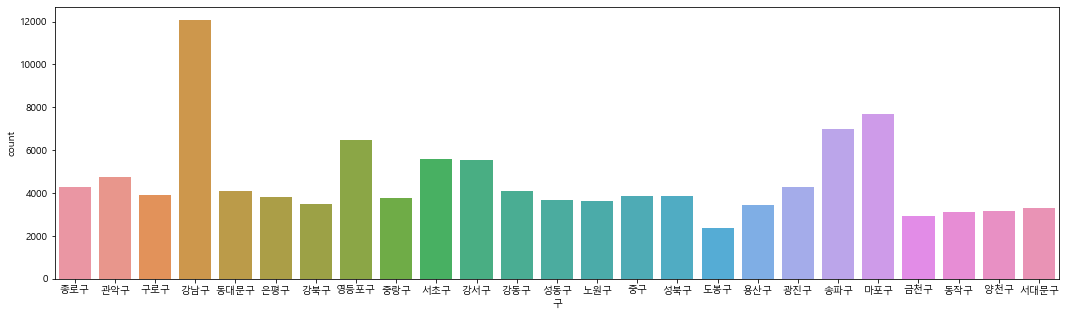

In [19]:
plt.figure(figsize=(18,5))
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.countplot(df['구'])
plt.show()

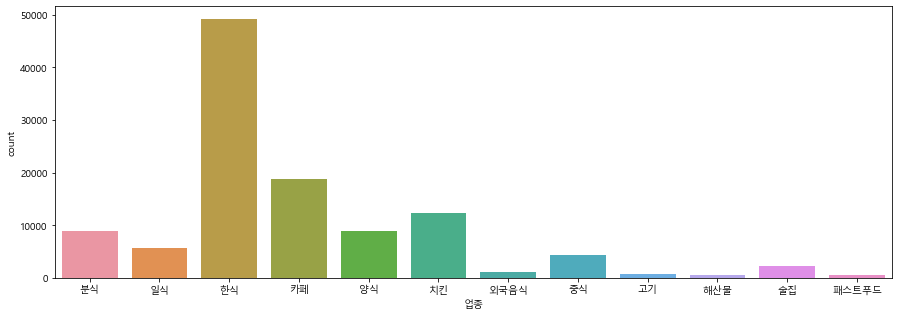

In [20]:
plt.figure(figsize=(15,5))
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.countplot(df['업종'])
plt.show()

In [21]:
df = df.reset_index(drop=True)
df.head()

,구,동,사업장명,업종,좌표정보(X),좌표정보(Y)
0,종로구,관철동,상해,분식,198867.702591,451824.281126
1,관악구,신림동,미쿠,일식,193687.348199,442284.164025
2,구로구,구로동,여름엔빙수겨울엔떡국,한식,189814.305919,443046.239859
3,강남구,대치동,카페디퍼,카페,204776.548264,444677.642985
4,동대문구,신설동,메이크데이(MakeDay),카페,202114.228397,452392.093759


### 자치구, 자치동, 음식종류 입력받아 음식점 리스트 반환 (이부분은 안쓰셔도 될거 같습니다 현경님)

In [22]:
# print('자치구 목록:', end= ' ')
# for i in list(df['구'].unique()):
#     print(i, end=', ')
# print()
# print('원하시는 자치구를 입력해주세요:')
# gu = input()

# print('자치동 목록:', end=' ')
# for i in list(df[df['구'] == gu]['동'].unique()):
#     print(i, end=', ')
# print()
# print('원하시는 자치동을 입력해주세요:')
# dong = input()

# print('음식종류 목록: 상관없음', end=', ')
# for i in list(df['업종'].unique()):
#     print(i, end=', ')
# print()
# print('원하시는 음식종류를 입력해주세요:')
# food = input()

# if food == '상관없음':
#     food_list = df[df['구'] == gu][df['동'] == dong]['사업장명'].tolist()
# else:
#     food_list = df[df['구'] == gu][df['동'] == dong][df['업종'] == food]['사업장명'].tolist()

# keyword_list = [gu+' '+dong+' '+i for i in food_list]
#동작구 흑석동 상관없음

### 전처리 데이터 저장

In [23]:
# df.to_csv('./seoul_food.csv',encoding='cp949',index=False)